### **Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Dense, Bidirectional, LSTM, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Input, Reshape, StringLookup
from keras.src.layers import Lambda
import os
import cv2
from tensorflow.keras.utils import Sequence
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Bidirectional, Dense, LSTM, Lambda
from keras.initializers import he_normal
from keras.models import Model
import tensorflow as tf

2025-01-22 10:27:38.217574: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-22 10:27:38.217718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-22 10:27:38.343717: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### **Config**

In [2]:
data_path = '/kaggle/input/handwriting-images-dataset'
train_path = '/kaggle/input/handwriting-images-dataset/training_data'
test_path = '/kaggle/input/handwriting-images-dataset/new_public_test'
label_path = '/kaggle/input/handwriting-images-dataset/train_gt.txt'
csv_path = '/kaggle/working/data'
Image_path = '/kaggle/working/Image/his_train.png'
Model_path = '/kaggle/working/Result/Model_checkpoint.keras'
Image_Width = 128
Image_Height = 32
Batch_Size = 128
vocab = "-ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚÝàáâãèéêìíòóôõùúýĂăĐđĨĩŨũƠơƯưẠạẢảẤấẦầẨẩẪẫẬậẮắẰằẲẳẴẵẶặẸẹẺẻẼẽẾếỀềỂểỄễỆệỈỉỊịỌọỎỏỐốỒồỔổỖỗỘộỚớỜờỞởỠỡỢợỤụỦủỨứỪừỬửỮữỰựỲỳỴỵỶỷỸỹ"
Max_Length = 17
activation = "relu"

In [3]:
# Đường dẫn của thư mục chính
main_folder = '/kaggle/working/'

# Tạo thư mục chính nếu nó không tồn tại
if not os.path.exists(main_folder):
    os.makedirs(main_folder)

# Danh sách các thư mục con bạn muốn tạo
sub_folders = ['data', 'Image', 'Result']

# Tạo các thư mục con trong thư mục chính
for folder in sub_folders:
    sub_folder_path = os.path.join(main_folder, folder)
    if not os.path.exists(sub_folder_path):
        os.makedirs(sub_folder_path)

### **Preparedata**

In [4]:
class Preparedata:
    def __init__(self, train_path, test_path, label_path):
        """
        Khởi tạo một đối tượng Preparedata với các đường dẫn đến thư mục chứa dữ liệu huấn luyện, dữ liệu kiểm tra,
        và nhãn của dữ liệu huấn luyện.

        Parameters:
            train_path (str): Đường dẫn đến thư mục chứa dữ liệu huấn luyện.
            test_path (str): Đường dẫn đến thư mục chứa dữ liệu kiểm tra.
            label_path (str): Đường dẫn đến tệp chứa nhãn của dữ liệu huấn luyện.
        """
        self.train_path = train_path
        self.test_path = test_path
        self.label_path = label_path

    @staticmethod
    def load_train_data():
        """
        Load dữ liệu huấn luyện từ các tệp nhãn và tạo một DataFrame chứa các thông tin về đường dẫn file và nhãn
        tương ứng.

        Returns:
            DataFrame: DataFrame chứa thông tin về đường dẫn file và nhãn của dữ liệu huấn luyện.
        """
        train_data = os.path.join(label_path)
        f = open(train_data, encoding="utf8")
        lines = f.readlines()
        train_labels = dict()
        for line in lines:
            img, label = line.split()
            train_labels[img] = label
        file_path = list(train_labels.keys())
        labels = list(train_labels.values())
        data = list(zip(file_path, labels))
        Dataframe = pd.DataFrame(data, columns=['filename', 'label'])

        # Thêm đường dẫn thư mục chứa dữ liệu huấn luyện vào tên file trong DataFrame
        Dataframe["filename"] = [train_path + f"/{filename}" for filename in Dataframe["filename"]]

        # Lưu DataFrame vào tệp CSV
        csv_file_path = os.path.join(csv_path, 'train_data.csv')
        Dataframe.to_csv(csv_file_path, index=False)

        return Dataframe

In [5]:
pre = Preparedata(train_path, test_path, label_path)
data = pre.load_train_data()
data

,filename,label
0,/kaggle/input/handwriting-images-dataset/train...,Thỗn
1,/kaggle/input/handwriting-images-dataset/train...,May-So
2,/kaggle/input/handwriting-images-dataset/train...,nhẹn
3,/kaggle/input/handwriting-images-dataset/train...,hàu
4,/kaggle/input/handwriting-images-dataset/train...,Quấy
...,...,...
102995,/kaggle/input/handwriting-images-dataset/train...,el
102996,/kaggle/input/handwriting-images-dataset/train...,nq
102997,/kaggle/input/handwriting-images-dataset/train...,QĐ
102998,/kaggle/input/handwriting-images-dataset/train...,Logarithm


### **Built Vocabulary**

In [6]:
labels = list(data.label)
char_list = set()
for label in labels:
    char_list.update(set(label))
vocab = sorted(char_list)
vocab = "".join(vocab)
print(vocab)

-ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚÝàáâãèéêìíòóôõùúýĂăĐđĨĩŨũƠơƯưẠạẢảẤấẦầẨẩẪẫẬậẮắẰằẲẳẴẵẶặẸẹẺẻẼẽẾếỀềỂểỄễỆệỈỉỊịỌọỎỏỐốỒồỔổỖỗỘộỚớỜờỞởỠỡỢợỤụỦủỨứỪừỬửỮữỰựỲỳỴỵỶỷỸỹ


In [7]:
print(len(vocab))

187


In [8]:
Max_Length = max(map(len, data.label))
print(f"Maximum length of a label : {Max_Length}")

Maximum length of a label : 17


### **Preprocessing data**

In [9]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    decode_image = tf.image.decode_jpeg(contents=image, channels=1)
    convert_image = tf.image.convert_image_dtype(image=decode_image, dtype=tf.float32)
    resize_image = tf.image.resize(images=convert_image, size=(Image_Height, Image_Width))
    image = tf.cast(resize_image, dtype = tf.float32)
    return image

In [10]:
print(list(vocab))

['-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'À', 'Á', 'Â', 'Ã', 'È', 'É', 'Ê', 'Ì', 'Í', 'Ò', 'Ó', 'Ô', 'Õ', 'Ù', 'Ú', 'Ý', 'à', 'á', 'â', 'ã', 'è', 'é', 'ê', 'ì', 'í', 'ò', 'ó', 'ô', 'õ', 'ù', 'ú', 'ý', 'Ă', 'ă', 'Đ', 'đ', 'Ĩ', 'ĩ', 'Ũ', 'ũ', 'Ơ', 'ơ', 'Ư', 'ư', 'Ạ', 'ạ', 'Ả', 'ả', 'Ấ', 'ấ', 'Ầ', 'ầ', 'Ẩ', 'ẩ', 'Ẫ', 'ẫ', 'Ậ', 'ậ', 'Ắ', 'ắ', 'Ằ', 'ằ', 'Ẳ', 'ẳ', 'Ẵ', 'ẵ', 'Ặ', 'ặ', 'Ẹ', 'ẹ', 'Ẻ', 'ẻ', 'Ẽ', 'ẽ', 'Ế', 'ế', 'Ề', 'ề', 'Ể', 'ể', 'Ễ', 'ễ', 'Ệ', 'ệ', 'Ỉ', 'ỉ', 'Ị', 'ị', 'Ọ', 'ọ', 'Ỏ', 'ỏ', 'Ố', 'ố', 'Ồ', 'ồ', 'Ổ', 'ổ', 'Ỗ', 'ỗ', 'Ộ', 'ộ', 'Ớ', 'ớ', 'Ờ', 'ờ', 'Ở', 'ở', 'Ỡ', 'ỡ', 'Ợ', 'ợ', 'Ụ', 'ụ', 'Ủ', 'ủ', 'Ứ', 'ứ', 'Ừ', 'ừ', 'Ử', 'ử', 'Ữ', 'ữ', 'Ự', 'ự', 'Ỳ', 'ỳ', 'Ỵ', 'ỵ', 'Ỷ', 'ỷ', 'Ỹ', 'ỹ']


In [11]:
char_to_number = StringLookup(vocabulary = list(vocab), mask_token = None)

number_to_char = StringLookup(vocabulary = char_to_number.get_vocabulary(), mask_token = None, invert = True)

In [12]:
def encode(image_path, label):
    image = load_image(image_path)
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    vector = char_to_number(chars)
    pad_size = Max_Length - tf.shape(vector)[0]
    vector = tf.pad(vector, paddings = [[0, pad_size]], constant_values=len(vocab)+1)
    return {"image":image, "label":vector}

In [13]:
train_df, test = train_test_split(data, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test, test_size=0.5, random_state=42)

In [14]:
length_data = len(train_df) + len(val_df) +len(test_df)
length_data == len(data)

True

In [15]:
import tensorflow.data as tfd
AUTOTUNE = tfd.AUTOTUNE

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((np.array(train_df['filename'].to_list()), np.array(train_df['label'].to_list()))).shuffle(1000).map(encode, num_parallel_calls=AUTOTUNE).batch(Batch_Size).prefetch(AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((np.array(val_df['filename'].to_list()), np.array(val_df['label'].to_list()))).shuffle(1000).map(encode, num_parallel_calls=AUTOTUNE).batch(Batch_Size).prefetch(AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((np.array(test_df['filename'].to_list()), np.array(test_df['label'].to_list()))).shuffle(1000).map(encode, num_parallel_calls=AUTOTUNE).batch(Batch_Size).prefetch(AUTOTUNE)

In [17]:
print(f"Training Data Size:{tf.data.Dataset.cardinality(train_dataset).numpy() * Batch_Size}")
print(f"Validation Data Size:{tf.data.Dataset.cardinality(val_dataset).numpy() * Batch_Size}")
print(f"Testing Data Size:{tf.data.Dataset.cardinality(test_dataset).numpy() * Batch_Size}")

Training Data Size:82432
Validation Data Size:10368
Testing Data Size:10368


In [18]:
for batch in test_dataset:
    images, labels = batch['image'], batch['label']


In [19]:
images.shape

TensorShape([60, 32, 128, 1])

In [20]:
labels

<tf.Tensor: shape=(60, 17), dtype=int64, numpy=
array([[ 15,   9, 120, ..., 188, 188, 188],
       [ 59, 188, 188, ..., 188, 188, 188],
       [ 89,  81,  36, ..., 188, 188, 188],
       ...,
       [ 88, 103,  48, ..., 188, 188, 188],
       [ 12,  35,  32, ..., 188, 188, 188],
       [ 15,  34,  35, ..., 188, 188, 188]])>

### **Loss Function**

In [21]:
from tensorflow.keras import layers
class CTCLayer(layers.Layer):

    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')

        input_len = tf.cast(tf.shape(y_pred)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_len, label_len)

        self.add_loss(loss)

        return y_pred

### **Model**

In [22]:
images = Input(shape=(Image_Height, Image_Width, 1), name="image")
labels = Input(shape=(None, ), name="label")
    
x = Conv2D(filters=16, kernel_size=(3, 3), strides=1, activation=activation, padding='same', kernel_initializer=he_normal())(images)
x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)

x = Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation=activation, padding='same', kernel_initializer=he_normal())(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 1))(x)

x = Conv2D(filters=64, kernel_size=(3, 3), strides=1, activation=activation, padding='same', kernel_initializer=he_normal())(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 1))(x)

x = Conv2D(filters=128, kernel_size=(3, 3), strides=1, activation=activation, padding='same', kernel_initializer=he_normal())(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(3, 1))(x)

x = Lambda(lambda x: tf.squeeze(x, axis=1), name='squeeze')(x)

blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(x)
blstm_2 = Bidirectional(LSTM(64, return_sequences=True))(blstm_1)

output = Dense(len(char_to_number.get_vocabulary())+1, activation="softmax", name="output")(blstm_2)

ctc_layer = CTCLayer()(labels, output)

model = Model(inputs=[images, labels], outputs=[ctc_layer], name="CRNN_Model")
model.summary()

Model: "CRNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 32, 128,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 128,   │        160 │ image[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 63, 32) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 63, 64) │     18,496 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 4, 62, 64) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 62,     │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 1, 60,     │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze (Lambda)    │ (None, 60, 128)   │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 60, 256)   │    263,168 │ squeeze[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 60, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 60, 189)   │     24,381 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_layer           │ (None, 60, 189)   │          0 │ label[0][0],      │
│ (CTCLayer)          │                   │            │ output[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 549,053 (2.09 MB)

 Trainable params: 549,053 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# images = layers.Input(shape=(Image_Height, Image_Width, 1), name="image")
# labels = layers.Input(shape=(None, ), name="label")

# x = layers.Conv2D(filters=32, kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')(image)
# x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# x = layers.Conv2D(filters=64, kernel_size=3, strides=1,padding='same',activation='relu',kernel_initializer='he_normal')(x)
# x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# encoding = layers.Reshape(target_shape=((Image_Width//4), (Image_Height//4)*64))(x)
# encoding = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(encoding)
# encoding = layers.Dropout(0.2)(encoding)

# x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(encoding)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

# output = layers.Dense(len(char_to_number.get_vocabulary())+1, activation='softmax', name="output")(x)

# ctc_layer = CTCLayer()(label, output)

# ocr_model = keras.Model(inputs=[image, label], outputs=[ctc_layer], name="CRNN_model")
# ocr_model.summary()

### **Trainning Model**

In [24]:
def plot(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(Image_path)
    plt.show()

In [25]:
model.compile(optimizer=Adam(learning_rate=0.001))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(Model_path, monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)

Epoch 1/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 112s 164ms/step - loss: 26.5952 - val_loss: 16.4919 - learning_rate: 0.0010
Epoch 2/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 73s 114ms/step - loss: 15.9311 - val_loss: 14.0539 - learning_rate: 0.0010
Epoch 3/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 74s 114ms/step - loss: 13.3594 - val_loss: 10.8525 - learning_rate: 0.0010
Epoch 4/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 75s 116ms/step - loss: 10.0019 - val_loss: 8.0193 - learning_rate: 0.0010
Epoch 5/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 74s 115ms/step - loss: 7.3004 - val_loss: 6.0203 - learning_rate: 0.0010
Epoch 6/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 74s 115ms/step - loss: 5.4416 - val_loss: 4.5553 - learning_rate: 0.0010
Epoch 7/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 75s 116ms/step - loss: 4.1711 - val_loss: 3.8229 - learning_rate: 0.0010
Epoch 8/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 74s 115ms/step - loss: 3.4109 - val_loss: 3.2503 - learning_rate: 0.0010
Epoch 9/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 74s 114ms/step - loss: 2.8864 - val_los

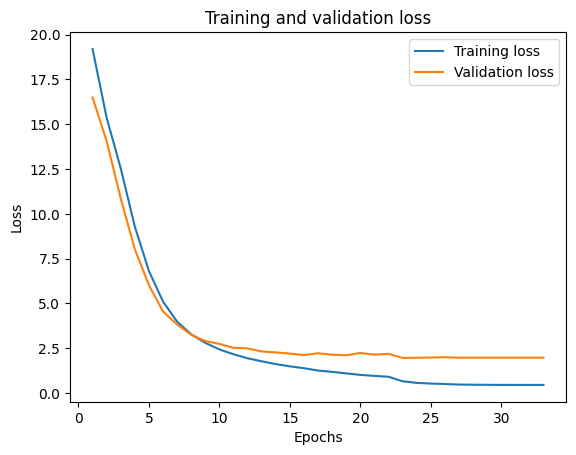

In [26]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)
plot(history)

In [27]:
# Mô hình dự đoán
model = Model(
    inputs=images,
    outputs=model.get_layer(name='output').output
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 32, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 128, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 63, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 63, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 62, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 62, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 60, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ squeeze (Lambda)                │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 60, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 60, 189)        │        24,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,053 (2.09 MB)

 Trainable params: 549,053 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

### **Make Predict**

In [28]:
def decode_pred(pred_label):

    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]

    # CTC decode
    decode = keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:Max_Length]

    # Converting numerics back to their character values
    chars = number_to_char(decode)

    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]

    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]

    return filtered_texts

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


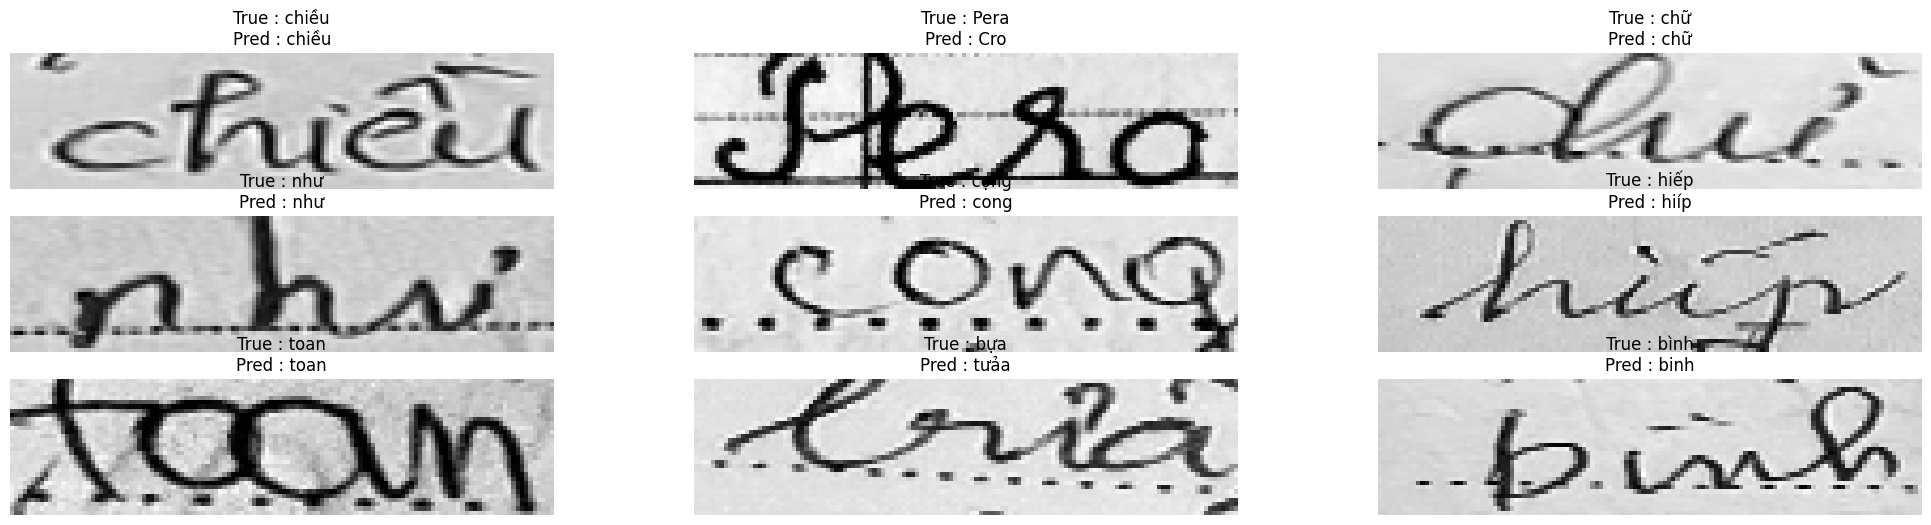

In [29]:
def show_images(data, GRID=[3, 3], FIGSIZE=(25, 6), cmap='binary_r', model=None, decode_pred=None):
    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID

    # Loading Data
    data = next(iter(data))
    images, labels = data['image'], data['label']

    # Ensure you have exactly n_rows * n_cols images to display
    num_images = n_rows * n_cols
    if len(images) < num_images:
        raise ValueError(f"Data contains only {len(images)} images, but {num_images} are required for the specified GRID.")

    # Iterate over the data
    for index, (image, label) in enumerate(zip(images[:num_images], labels[:num_images])):

        # Label processing
        text_label = number_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()

        # Create a sub plot
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(tf.transpose(image, perm=[0, 1, 2]), cmap=cmap)
        plt.axis('off')

        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    plt.show()
show_images(data=test_dataset, model=model, decode_pred=decode_pred)

In [30]:
y_pred = model.predict(test_dataset)

81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step


In [31]:
print(decode_pred(y_pred))

['ổ-Lếp', 'trên', 'híc', 'giái', 'trết', 'rắn', 'phỗng', 'XỨC', 'mệt', 'can', 'ngyên', 'LỬ', 'manh', 'rỉ', 'LỞI', 'TÊT', 'Anh', 'gian', 'diết', 'Phúc', 'khăn', 'ta', 'quyên', 'HỌC', 'Miiu', 'phì', 'tê', 'Xoạt', 'hãnh', 'như', 'ngời', 'biệt', 'tc-can', 'cho', 'ditham', 'giộ', 'GIGABIT', 'ca-nông', 'sách', 'tưảa', 'đê', 'CHUỘT', 'MÒU', 'rỜ', 'sư', 'HỎM', 'hát', 'GUỒNG', 'phơ', 'đỉnh', 'một', 'thêt', 'xuất', 'Khúm', 'nhủ', 'RNY-ÔNG', 'NONO', 'áp', 'Nhất', 'nươc', 'XÓA', 'nhân', 'MUA', 'thiếu', 'đơ', 'Đằng', 'Cạp', 'Bẹt', 'BAI-T', 'PHỆT', 'XÍCH', 'BẪY', 'tiếng', 'rp', 'lăng', 'còi', 'Choe', 'người', 'minh', 'NGHIỆP', 'đê', 'cẵng', 'dưng', 'đâu', 'Thanh', 'ĐUỔI', 'DIOPTR', 'hám', 'minh', 'mru', 'RỆN', 'gia-tuýt', 'AẠNG', 'thỉch', 'nghiệm', 'cám', 'ngay', 'xỏng', 'TÊ-LẾCH', 'u-ra-ni', 'Đuán', 'nhàng', 'TẬT', 'tiên', 'nam', 'HÂN', 'Linin', 'chặng', 'cương', 'phát', 'CỔI', 'nhà', 'ngáu', 'Dấm', 'Vp', 'MB', 'tăm', 'THIỂN', 'NGÃI', 'thùy', 'mau', 'dũng', 'trao', 'qua', 'mát', 'pgs', 'thường', 't

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


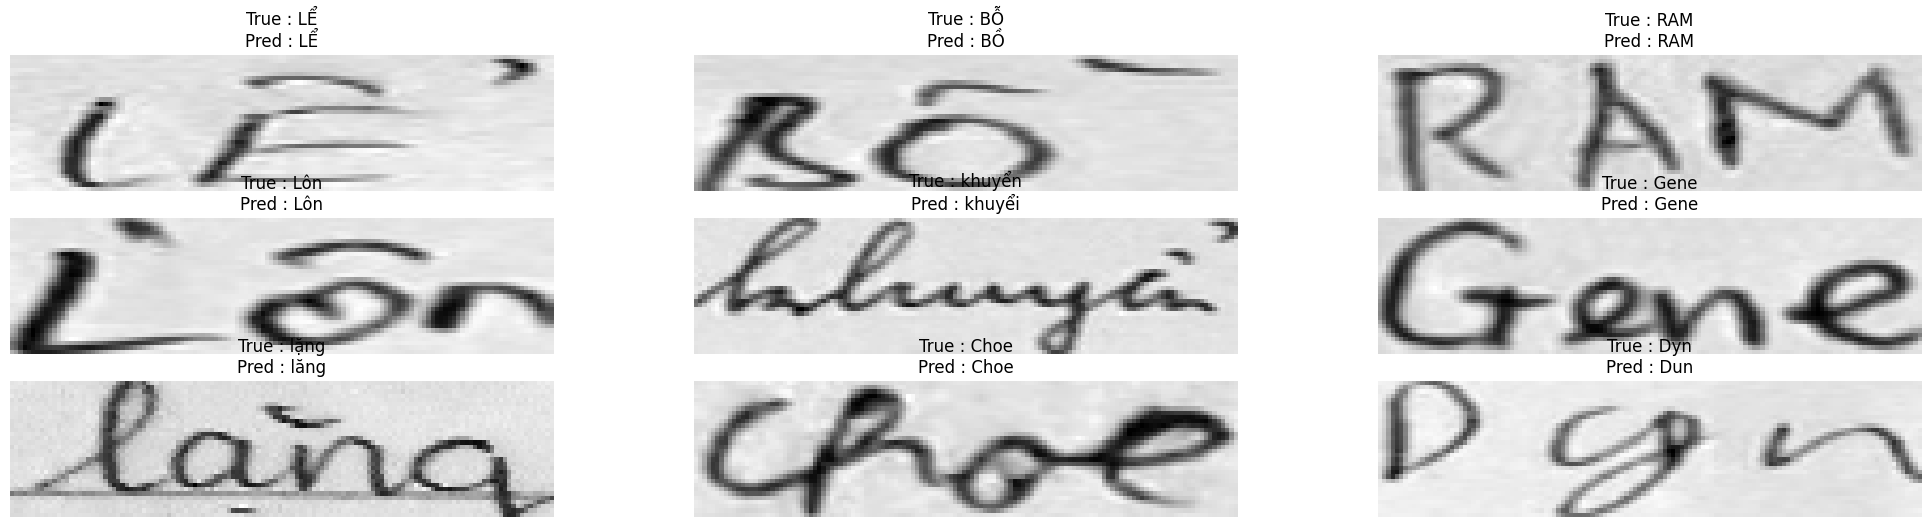

In [32]:
show_images(data=test_dataset, model=model, decode_pred=decode_pred)

### **Caculate metric**

In [33]:
for batch in test_dataset:
    images, labels = batch['image'], batch['label']

In [34]:
y_true = labels.numpy()
y_true

array([[ 46,  95,  41, ..., 188, 188, 188],
       [ 49,  76,   1, ..., 188, 188, 188],
       [ 34,  35,  75, ..., 188, 188, 188],
       ...,
       [ 45, 161,  41, ..., 188, 188, 188],
       [ 15,  35,  95, ..., 188, 188, 188],
       [ 17,  35,  97, ..., 188, 188, 188]])

In [35]:
chars = number_to_char(y_true)

# Join all the characters
texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]

# Remove the unknown token
filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]
filtered_texts 


['sơn',
 'vê-lanh',
 'ghép',
 'CNTB',
 'Véc-Tơ',
 'cốm',
 'BỆT',
 'ngươi',
 'Làm',
 'Hèm',
 'dung',
 'ngất',
 'chính',
 'CHỘI',
 'đê',
 'hình',
 'sú-ba-giăng',
 'NHỪA',
 'sông',
 'quát',
 'yếu',
 'sét',
 'minh',
 'khúc',
 'Đảng',
 'nhưng',
 'SIỂNG',
 'NHỔ',
 'tăng',
 'CHUÔM',
 'Thô',
 'như',
 'BỈU',
 'Òn',
 'cao',
 'phầm',
 'chưa',
 'pẻ',
 'loài',
 'ngơ',
 'cơ',
 'Dứng',
 'thác',
 'cách',
 'Tằn',
 'ngang',
 'hệt',
 'cách',
 'song',
 'chốc',
 'Nen',
 'Ngận',
 'Phơ',
 'cây',
 'ĐÁNG',
 'tranh',
 'những',
 'rởn',
 'Nhơ',
 'Phương']

In [36]:
y_pred = model.predict(images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


In [37]:
y_pred.shape

(60, 60, 189)

In [38]:
a = decode_pred(y_pred)
a

['sớn',
 'vê-lanh',
 'ghêp',
 'CNT',
 'Véc-Tơ',
 'cấn',
 'BỆT',
 'ngươi',
 'Làm',
 'hèm',
 'dung',
 'ngất',
 'chính',
 'CHỘI',
 'đê',
 'hình',
 'cíú-liu-găng',
 'NHỪA',
 'sông',
 'quát',
 'Yếu',
 'sêt',
 'minh',
 'khúc',
 'Đáng',
 'nhưng',
 'SIỂNG',
 'NHỔ',
 'tặng',
 'GHUÔM',
 'Thê',
 'như',
 'BỈU',
 'Òn',
 'cao',
 'phầm',
 'chưa',
 'pẻ',
 'loài',
 'ngơ',
 'cơ',
 'Dứng',
 'thác',
 'cách',
 'TÀ',
 'ngung',
 'hệt',
 'cach',
 'sông',
 'chốc',
 'Nen',
 'Ngận',
 'Phơ',
 'cây',
 'ĐÁNG',
 'tanh',
 'những',
 'rởn',
 'Nhớ',
 'Phương']

In [39]:
from torchmetrics.text import CharErrorRate
cer = CharErrorRate()
cer(a, filtered_texts)


tensor(0.1068)